# Optimization via Stochastic Gradient Descent

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

np.random.seed(42)

In [3]:
def sgd(loss, grad_loss, w0, data, batch_size, n_epochs, lr):
    X, y = data
    data_size = X.shape[1]
    curr_w = w0
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_loss(w0, X, y)]
    history_err = [np.linalg.norm(history_grad[-1], 2)]

    for _ in range(n_epochs):
        idxs = np.arange(0, data_size)
        np.random.shuffle(idxs)

        for i in range(math.ceil(data_size / batch_size)):
        # for i in range(data_size // batch_size):
            batch_idxs = idxs[i*batch_size : (i+1)*batch_size]
            batch_X = X[:, batch_idxs]
            batch_y = y[batch_idxs]

            curr_w = curr_w - lr*grad_loss(curr_w, batch_X, batch_y)

        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(grad_loss(curr_w, X, y))
        history_err.append( np.linalg.norm(history_grad[-1], 2) )

    return history_w, history_loss, history_grad, history_err

In [4]:
def backtracking(loss, grad_loss, w, data):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    X, y = data
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while loss(w - alpha * grad_loss(w, X, y), X, y) > loss(w, X, y) - c * alpha * np.linalg.norm(grad_loss(w, X, y), 2) ** 2:
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha


def gd(loss, grad_loss, w0, data, k_max, tol_loss, tol_w, alpha=None):
    X, y = data
    curr_w, prev_w = w0, np.inf
    curr_k = 0
    grad_x0, curr_grad = grad_loss(w0, X, y), grad_loss(curr_w, X, y)
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_x0]
    history_err = [np.linalg.norm(grad_x0, 2)]
    use_backtracking = alpha is None

    while (curr_k < k_max and 
            not (np.linalg.norm(curr_grad, 2) < tol_loss*np.linalg.norm(grad_x0, 2)) and
            not (np.linalg.norm(curr_w - prev_w, 2) < tol_w)):
        if use_backtracking:
            alpha = backtracking(loss, grad_loss, curr_w, data)
        prev_w = curr_w
        curr_w = curr_w - alpha*grad_loss(curr_w, X, y)

        curr_grad = grad_loss(curr_w, X, y)
        curr_k += 1
        
        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(curr_grad)
        history_err.append(np.linalg.norm(curr_grad, 2))

    return history_w, curr_k, history_loss, history_grad, history_err

In [5]:
def train_test_split(X, Y, train_size):
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test


def createDataset(X, Y, digits, classification_type="binary", train_ratio=0.75):
    select_mask = np.full(Y.shape, False)
    for d in digits:
        select_mask = select_mask | (Y == d)
    
    X = X[:, select_mask]
    Y = Y[select_mask]

    if classification_type == "binary":
        Y[Y == digits[0]] = 0
        Y[Y == digits[1]] = 1
    elif classification_type == "multi":
        n_classes = len(digits)
        Y = np.array([ [0]*((digits.index(d))) + [1] + [0]*((n_classes - digits.index(d)-1)) for d in Y ])
    else: raise Exception("Invalid type")

    return train_test_split(X, Y, int(train_ratio*X.shape[1]))

In [6]:
def addColumn(A):
    out = np.ones((A.shape[0]+1, A.shape[1]))
    out[1:, :] = A
    return out

data = pd.read_csv("../homework2/data/data.csv")
data = data.to_numpy()

full_X = addColumn(data[:, 1:].T)
full_Y = data[:, 0].T
print(full_X.shape, full_Y.shape)

(785, 42000) (42000,)


## Binary classification

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(w, x):
    return sigmoid(x.T @ w)


def mse(fn, w, X, y):
    N = X.shape[1]
    return (1/(2*N)) * np.linalg.norm(fn(w, X) - y, 2)**2

def mse_grad(fn, w, X, y):
    N = X.shape[1]
    fn_X = fn(w, X)
    return (1/N) * ( X @ (fn_X * (1-fn_X) * (fn_X - y)) )


def loss(w, X, Y):
    return mse(f, w, X, Y)

def grad_loss(w, X, Y):
    return mse_grad(f, w, X, Y)

In [8]:
def evaluate(w, X_test, Y_test, threshold=0.5):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_prob = f(w, X_test[:, i])
        # print(f"{pred_prob:.2f}", end=" ")
        
        if pred_prob >= threshold:
            pred = 1
        else:
            pred = 0
            
        if pred == Y_test[i]:
            correct += 1

    return correct, correct / N

In [9]:
digits = [8, 9]
X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, digits, classification_type="binary")
print("Train", (Y_train == 0).sum(), (Y_train == 1).sum())
print("Test", (Y_test == 0).sum(), (Y_test == 1).sum())

Train 3071 3117
Test 992 1071



 0.971885603490063


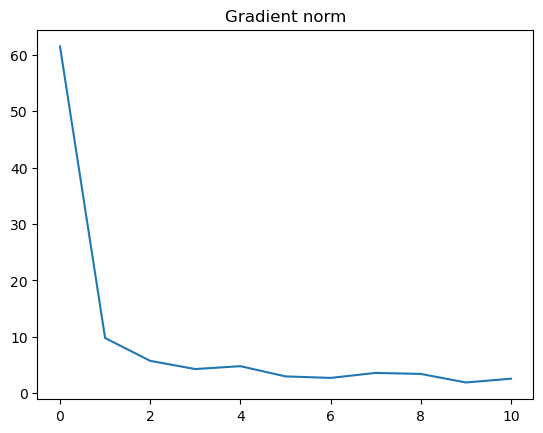

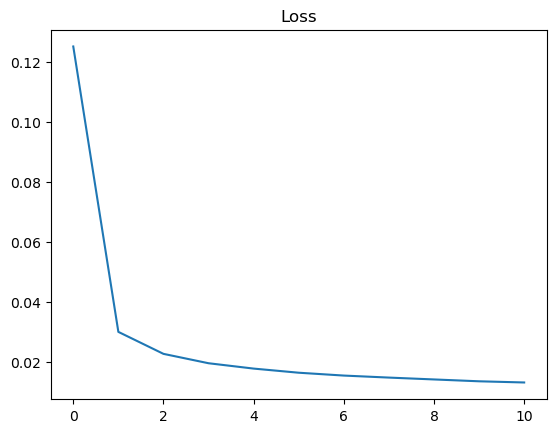

In [10]:
history_w, history_loss, history_grad, history_err = sgd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 500, 10, 1e-5)
# history_w, curr_k, history_loss, history_grad, history_err = gd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 5, 1e-8, 1e-8)

correct, accuracy = evaluate(history_w[-1], X_test, Y_test)
print("\n", accuracy)

plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.show()

plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

In [11]:
def binaryDigitEvaluation(digit1, digit2):
    X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [digit1, digit2])

    history_w_sgd, _, _, _ = sgd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 100, 15, 1e-6)
    history_w_gd, _, _, _, _ = gd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 5, 1e-10, 1e-10)

    correct, accuracy_sgd = evaluate(history_w_sgd[-1], X_test, Y_test)
    correct, accuracy_gd = evaluate(history_w_gd[-1], X_test, Y_test)
    
    print(f"------ Classifying {digit1} {digit2} ------")
    print(f"||w_sgd - w_gd ||_2 = {np.linalg.norm(history_w_sgd[-1] - history_w_gd[-1])}")
    print(f"SGD acc. = {accuracy_sgd} | GD acc. {accuracy_gd}")

binaryDigitEvaluation(0, 1)
binaryDigitEvaluation(8, 9)

/tmp/ipykernel_706383/3489188747.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


------ Classifying 0 1 ------
||w_sgd - w_gd ||_2 = 0.10960125315280782
SGD acc. = 0.9977313974591652 | GD acc. 0.9918330308529946
------ Classifying 8 9 ------
||w_sgd - w_gd ||_2 = 0.05403244247746689
SGD acc. = 0.9689772176442074 | GD acc. 0.9510421715947649


## Multi-class classification

\begin{equation}
    w: N \times 3
\end{equation}

\begin{split}
    MSE&: (N \times 3) \rightarrow 1 \\
    \nabla MSE&: (N \times 3) \rightarrow (N \times 3)
\end{split}

\begin{split}
    \sigma&: 3 \rightarrow 3 \\
    \nabla\sigma&: 3 \rightarrow (3 \times 3)
\end{split}

\begin{split}
    f&: (N \times 3) \rightarrow 3 \\
    \nabla f&: (N \times 3) \rightarrow (3 \times N \times 3)
\end{split}

In [12]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def softmax_grad(z):
    # grad_matr = []
    # for i in range(z.shape[0]):
    #     grad_row = []
    #     for j in range(z.shape[0]):
    #         delta = 1 if i == j else 0
    #         grad_row.append( softmax(z)[i] * (delta - softmax(z)[j]) )
    #     grad_matr.append(grad_row)
    
    # return np.array(grad_matr)

    s = softmax(z)
    return np.diag(s) - np.outer(s, s)


def f_multi(w, x):
    return softmax(x.T @ w)

def f_multi_grad(w, x):
    def __grad(a):
        grad = softmax_grad(a.T @ w)
        out = np.array([ np.outer(a.T, grad[i, :]) for i in range(grad.shape[0]) ])
        return out
    
    if x.ndim == 1: return __grad(x)
    
    out = []
    for i_data in range(x.shape[1]):
        data = x[:, i_data]
        out.append(__grad(data))
        
    return np.array(out)
 

def mse(f, w, D):
    X, y = D
    N = X.shape[1]
    return (1/(2*N)) * (np.linalg.norm(f(w, X) - y, 2)**2)

def mse_grad(f, grad_f, w, D):
    X, y = D
    N = X.shape[1]
    grad = grad_f(w, X)
    f_x = f(w, X)

    out = []
    for i in range(N):
        grad_i = grad[i]
        f_x_i = f_x[i]
        y_i = y[i]
        out.append((1/N) * grad_i @ (f_x_i - y_i))

    return np.mean(np.array(out), axis=0).T


def loss_multi(w, X, Y):
    return mse(f_multi, w, (X, Y))

def grad_loss_multi(w, X, Y):
    return mse_grad(f_multi, f_multi_grad, w, (X, Y))

In [13]:
def evaluateMulti(w, X_test, Y_test):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_probs = f_multi(w, X_test[:, i])
        
        if np.argmax(pred_probs) == np.argmax(Y_test[i]):
            correct += 1

    return correct, correct / N

In [14]:
digits = [1, 8, 9]
X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, digits, classification_type="multi")

for digit, train_size, test_size in zip([d for d in digits], np.sum(Y_train, axis=0), np.sum(Y_test, axis=0)):
    print(f"{digit} | {train_size} train -- {test_size} test")

1 | 3566 train -- 1118 test
8 | 3005 train -- 1058 test
9 | 3130 train -- 1058 test


(3066, 0.948051948051948)


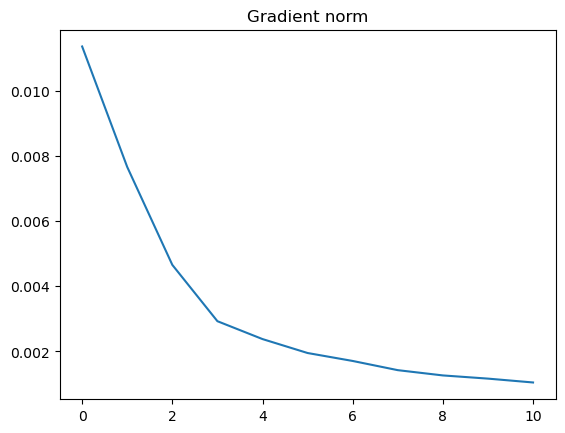

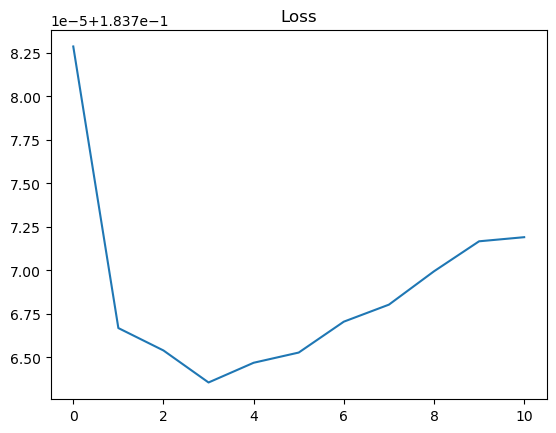

In [16]:
history_w, history_loss, history_grad, history_err = sgd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 500, 10, 5e-4
)
# history_w, curr_k, history_loss, history_grad, history_err = gd(
#     loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 5, 1e-8, 1e-8
# )

print(evaluateMulti(history_w[-1], X_test, Y_test))

plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.show()

plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()